# Step-01: Download Wikipedia Chinese Corpus: 
https://dumps.wikimedia.org/zhwiki/20190720/
第一步：使用维基百科下载中文语料库

# Step-02: Using https://github.com/attardi/wikiextractor to extract the wikipedia corpus
第二步：使用python wikipedia extractor抽取维基百科的内容

这里使用的是gensim的工具
``` shell
python -m gensim.scripts.segment_wiki -i -f zhwiki-20190720-pages-articles-multistream.xml.bz2 -o zhwiki-20190720.json
```

# Step-03: Using gensim get word vectors:
Reference:

https://radimrehurek.com/gensim/models/word2vec.html
https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
第三步：参考Gensim的文档和Kaggle的参考文档，获得词向量。 注意，你要使用Jieba分词把维基百科的内容切分成一个一个单词，然后存进新的文件中。然后，你需要用Gensim的LineSentence这个类进行文件的读取。

在训练成词向量Model.

## 准备语料

In [3]:
from gensim import corpora
import jieba
from pyltp import SentenceSplitter
from hanziconv import HanziConv
import json
import re
from multiprocessing import Process
import os
import multiprocessing
from gensim import utils
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence


In [2]:
def clean_doc(doc_str):
    """清理文档"""
    try:
        doc = json.loads(doc_str)
        ret = []
        for section_text in doc["section_texts"]:
            # 繁体转简体
            # 分句
            sents = SentenceSplitter.split(HanziConv.toSimplified(section_text))
            for i in sents:
                if not i or not i.strip():
                    continue
                # 分词
                sent = "".join(re.findall('\w+', i))
                if not sent:
                    continue
                words = jieba.lcut(sent, HMM=False)
                #         words = [s for s in words if s not in stopwords]
                ret.append(words)
        return ret
    except Exception as e:
        print(e)
        save_faild_doc(doc_str)

In [6]:
def save_faild_doc(doc):
    """保存失败的文档"""
    WRITE_PATH = r"E:\summer_nlp\lesson4\words\faild_doc.dat"
    with open(WRITE_PATH, mode="a", encoding="utf-8") as w:
        w.write(doc + "\n")


In [4]:
def get_sentens_from_wiki():
    """读取wiki文件并返回处理后的句子"""
    DATA_PATH = r"E:\summer_nlp\lesson4\zhwiki-20190720.json"
    processes = max(1, multiprocessing.cpu_count() - 1)
    # processes = 1
    pool = multiprocessing.Pool(processes)
    print("processes num: {}".format(processes))
    chunksize = 0
    for group in utils.chunkize(open(DATA_PATH, encoding="utf-8"), 100 * processes):
        for words in pool.imap(clean_doc, group):
            yield words
        chunksize += len(group)
        if chunksize % 10000 == 0:
            print("chunksize = {}".format(chunksize))
    print("chunksize = {}".format(chunksize))
    pool.terminate()


In [5]:
def clean_doc_to_words():
    """保存处理后的语料"""
    WRITE_PATH = r"E:\summer_nlp\lesson4\words\sentens.dat"
    write_cnt = 0
    with open(WRITE_PATH, mode="w", encoding="utf-8") as w:
        for doc_sentens in get_sentens_from_wiki():
            # w.write(" ".join(words) + "\n")
            if not doc_sentens:
                continue
            w.writelines([" ".join(words) for words in doc_sentens])
            write_cnt += len(doc_sentens)
            if write_cnt % 10000 == 0:
                print("write_cnt = {}".format(write_cnt))
    print("write_cnt = {}".format(write_cnt))

## 训练词向量

In [7]:
sentences = LineSentence(r"E:\summer_nlp\lesson4\words\sentens.dat")

In [8]:
model = Word2Vec(sentences, size=100, window=5, min_count=5, workers=31)

D:\Miniconda3\envs\py3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [9]:
model.save(r"E:\summer_nlp\lesson4\words\word2vec.model")

In [10]:
word_vectors = model.wv

In [11]:
del model

In [12]:
word_vectors["我"]

array([-3.1902962 , -0.36231822, -4.0532312 ,  1.2595682 ,  5.720885  ,
       -3.5357156 , -0.8755913 ,  2.5220826 ,  4.332223  , -3.4023552 ,
       -0.82885265, -1.026287  ,  1.3987124 ,  1.2187225 ,  0.94500226,
        2.123962  , -3.5414727 ,  0.09479561,  3.0509918 , -1.3351552 ,
       -0.24050075,  1.4841307 , -0.43615076, -2.0040991 ,  1.9128023 ,
       -0.5293957 ,  0.9274891 , -0.9149361 , -2.3298833 , -0.28858364,
        0.1312577 , -2.708171  , -1.6735983 , -0.93911564,  2.1888785 ,
       -2.6121078 , -0.96340084, -0.10118424, -0.41130105,  2.6200635 ,
       -0.70507604,  0.16305318,  2.4189286 , -2.3209984 , -1.8232613 ,
        3.9474566 ,  0.7344504 ,  0.6666732 ,  1.6776625 ,  2.6906643 ,
        1.8097285 ,  2.9653177 , -0.36692008, -0.86284125,  0.15111047,
       -1.8855729 ,  0.21542436,  1.5141146 ,  1.3091336 , -0.72064006,
       -0.6712115 ,  0.3235576 , -1.5715761 , -0.17445564, -1.4240502 ,
       -4.8346834 , -2.5250788 ,  0.75181353, -4.9615116 , -3.14

# Step-04: Using some words to test your preformance.
第四步，测试同义词，找几个单词。

In [13]:
word_vectors.most_similar(["我"])

[('你', 0.9366101026535034),
 ('妳', 0.9024286270141602),
 ('你我', 0.8451442718505859),
 ('我我', 0.8362391591072083),
 ('谁', 0.8037588596343994),
 ('你你', 0.7944913506507874),
 ('对不起', 0.7737680077552795),
 ('我你', 0.7724961042404175),
 ('你们', 0.7710360288619995),
 ('啊我', 0.7656038999557495)]

In [18]:
word_vectors.most_similar(["说"],topn=50 )

[('说道', 0.8071485757827759),
 ('所说', 0.7928475141525269),
 ('问道', 0.7427356243133545),
 ('却说', 0.7417651414871216),
 ('告诉', 0.7238739728927612),
 ('以为', 0.7203991413116455),
 ('回答', 0.714353084564209),
 ('问', 0.7081437110900879),
 ('答道', 0.7071371078491211),
 ('觉得', 0.7054300308227539),
 ('认为', 0.7014769315719604),
 ('反问', 0.6993587017059326),
 ('提到', 0.6984965801239014),
 ('相信', 0.6890735626220703),
 ('指出', 0.6869906187057495),
 ('暗示', 0.6787278652191162),
 ('直言', 0.678459882736206),
 ('为什么', 0.67844158411026),
 ('听说', 0.6780461668968201),
 ('写道', 0.6767325401306152),
 ('时说', 0.6764950156211853),
 ('感叹', 0.6757097244262695),
 ('说出', 0.6751658916473389),
 ('难道', 0.6750123500823975),
 ('说起', 0.6732645630836487),
 ('为何', 0.665115237236023),
 ('告诫', 0.6632875800132751),
 ('声称', 0.6593096852302551),
 ('表示', 0.6582745909690857),
 ('名言', 0.6566882133483887),
 ('反驳', 0.6537286043167114),
 ('断言', 0.6523622274398804),
 ('知道', 0.6479602456092834),
 ('责备', 0.6418394446372986),
 ('确信', 0.641635060

# Step-05: Using visualization tools: https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne

第五步：使用Kaggle给出的T-SEN进行词向量的可视化。

In [11]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 
matplotlib.rcParams['font.family']='sans-serif'
matplotlib.rcParams['axes.unicode_minus'] = False 
%matplotlib inline

In [5]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()


In [9]:
sentences = LineSentence(r"E:\summer_nlp\lesson4\words\sentens.dat")
model = Word2Vec(sentences, size=100, window=20, min_count=50000, workers=31)

D:\Miniconda3\envs\py3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


D:\Miniconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


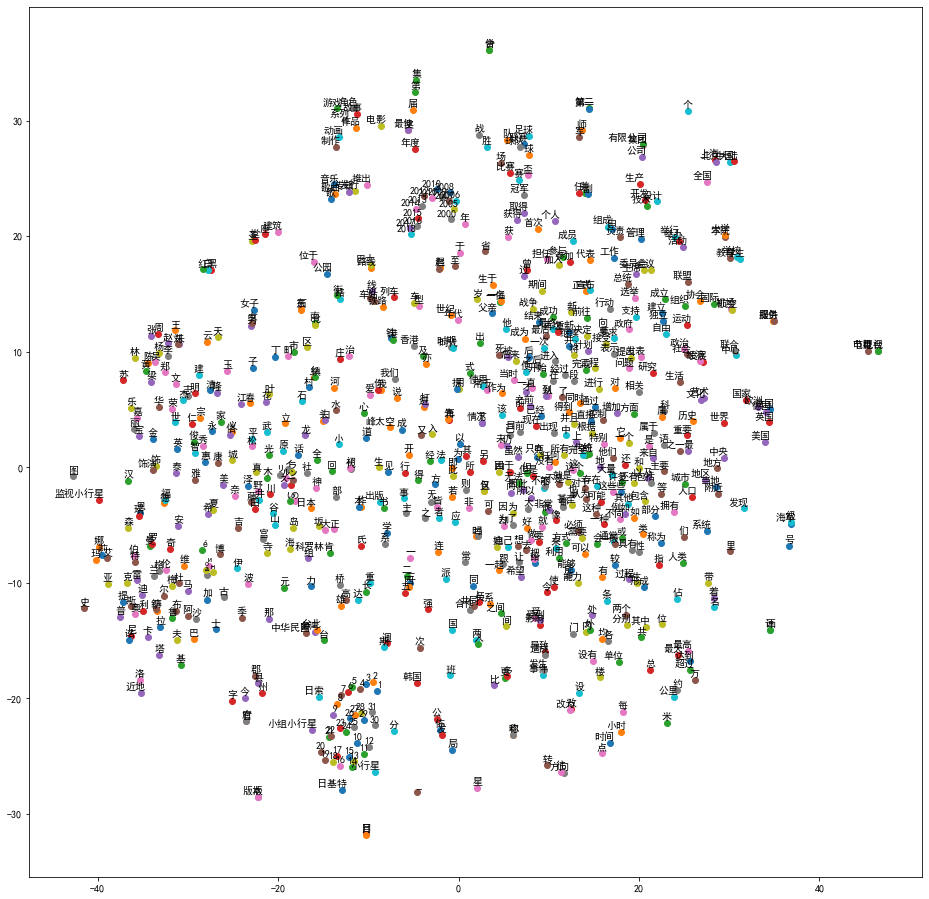

In [27]:
tsne_plot(model)